In [12]:
import numpy as np
import itertools
from typing import List, Tuple


# I need to implement a convolutional neural network with and adam optimizer
# using only numpy.  
# I will start by implementing a fully connected layer and build a plain neural network
# I think I need to implement a layer abstract class
# The layer class will have virtual methods for forward and backward pass
# Each succssor of the layer class will implement the forward and backward pass

# I will start with a fully connected layer without inheritance


class Layer:
    def __init__(self):
        pass
    
    def forward(self, input_: np.ndarray) -> np.ndarray:
        raise NotImplementedError
    
    def backward(self, output_gradient: np.ndarray) -> np.ndarray:
        raise NotImplementedError


class FullyConnectedLayer(Layer):
    
    id_iter = itertools.count()

    def __init__(self, n_input_neurons: int, n_output_neurons: int):
        # id is used to identify the layer's weights and bias in the optimizer
        self.id = next(FullyConnectedLayer.id_iter)
        self.weights = np.random.randn(n_input_neurons, n_output_neurons) * 0.001
        self.bias = np.random.randn(1, n_output_neurons) * 0.001

        #! Code below was not used. Was intended to be used in the optimizer
        """
        self.parameter_by_gradient_id = {
            f"dW{self.id}": self.weights,
            f"db{self.id}": self.bias
        }
        """
    
    def forward(self, input_: np.ndarray) -> np.ndarray:
        self.input_ = input_
        self.output = np.dot(self.input_, self.weights) + self.bias
        return self.output
    
    def backward(self, output_gradient: np.ndarray) -> np.ndarray:
        # The math explanation: https://web.eecs.umich.edu/~justincj/teaching/eecs442/notes/linear-backprop.html
        batch_size = output_gradient.shape[0]
        input_gradient = np.dot(output_gradient, self.weights.T)
        self.weights_gradient = np.dot(self.input_.T, output_gradient)
        self.bias_gradient = np.sum(output_gradient, axis=0, keepdims=True)
        self.W_and_b_grad = (self.weights_gradient, self.bias_gradient)
        return input_gradient
    
    def get_W_and_b_ids(self) -> Tuple[str, str]:
        weights_id = f"dW{self.id}"
        bias_id = f"db{self.id}"
        return weights_id, bias_id
    
    #! Code below was not used. Was intended to be used in the optimizer
    """
    def update_parameter_by_gradient_id(self, gradient_id: str, gradient: np.ndarray):
        self.parameter_by_gradient_id[gradient_id] = gradient
    """

class ActivationLayer(Layer):
    """
    This base class is not crucial but it presevrves OOP ideology and 
    it is useful for type hinting like List[ActivationLayer].
    """
    def __init__(self):
        pass

class ReLULayer(ActivationLayer):
    def forward(self, input_: np.ndarray) -> np.ndarray:
        self.input_ = input_
        return np.maximum(0, input_)
    
    def backward(self, output_gradient: np.ndarray) -> np.ndarray:
        return output_gradient * (self.input_ > 0)

class SigmoidLayer(ActivationLayer):
    def forward(self, input_: np.ndarray) -> np.ndarray:
        # clip is used to avoid overflow
        self.output = 1 / (1 + np.exp(-np.clip(input_, 1e-8, 1e2)))
        # self.output = 1 / (1 + np.exp(-input_))
        return self.output
    
    def backward(self, output_gradient: np.ndarray) -> np.ndarray:
        return output_gradient * self.output * (1 - self.output)

class LinearActivation(ActivationLayer):
    def forward(self, input_: np.ndarray) -> np.ndarray:
        return input_
    
    def backward(self, output_gradient: np.ndarray) -> np.ndarray:
        return output_gradient
        


class SoftMaxLayer(Layer):
    def forward(self, input_: np.ndarray) -> np.ndarray:
        self.output = np.exp(input_) / np.sum(np.exp(input_), axis=1, keepdims=True)
        return self.output
    
    #! backward needs to be checked
    def backward(self, output_gradient: np.ndarray) -> np.ndarray:
        return output_gradient * self.output * (1 - self.output)

        

class CrossEntropyLoss(Layer):
    def forward(self, pred: np.ndarray, target: np.ndarray) -> float:
        self.pred = pred
        self.target = target
        batch_size = pred.shape[0]
        # summing over the batch and then dividing by the batch size
        # The line below makes a division by zero error at some point
        return -np.sum(np.dot(self.target, np.log(self.pred).T)) / batch_size
    
    def backward(self) -> np.ndarray:
        return - self.target / self.pred


class Optimizer:
    def __init__(self, trainable_layers: List[Layer], learning_rate: float):
        self.learning_rate = learning_rate
        self.trainable_layers = trainable_layers
    
    def step(self):
        raise NotImplementedError

class AdamOptimizer(Optimizer):
    """
    I store m and v values for each weight gradient and bias gradient
    in dictionaries m and v where the key is the id of the parameter matrix
    which has the form "dW{layer_id}" or "db{layer_id}". Thus, the parameter
    matrix ids serve as gradient matrix ids.
    
    This solution works but I'm not sure that this approach could be used in a graph based computation. 

    There's also an ugly option to have an instance of AdamOptimizer for each.
    """
    #!? Maybe we should implement a class of a TrainableLayer that inherits from Layer. 
    def __init__(self, trainable_layers: List[Layer], learning_rate: float = 0.001,
                 beta1: float = 0.9, beta2: float = 0.999, epsilon: float = 1e-8):
        #!? maybe we should pass paramters and parameters' ids to the optimizer instead of passing layers
        self.trainable_layers = trainable_layers
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0
        for layer in self.trainable_layers:
            # ids of weights and biases are same as the ids of corresponding gradients
            W_id, b_id = layer.get_W_and_b_ids()
            #! I don't see any pros of using zeros_like instead of zeros, but decided to use it anyway.
            self.m[W_id] = np.zeros_like(layer.weights)
            self.m[b_id] = np.zeros_like(layer.bias)
            self.v[W_id] = np.zeros_like(layer.weights)
            self.v[b_id] = np.zeros_like(layer.bias)
        
    

    
    def update(self, gradient: np.ndarray, cache_id: str) -> None:
        self.m[cache_id] = self.beta1 * self.m[cache_id] + (1 - self.beta1) * gradient
        self.v[cache_id] = self.beta2 * self.v[cache_id] + (1 - self.beta2) * gradient ** 2
        
    def step(self) -> None:
        for layer in self.trainable_layers:
            #! Since np arrays are passed by reference the weights and bias
            # layer properties are going to be properly updated.
            # The loop approach seems to be more general.
            # On the other hand, the commented code below might be more readable
            # and it updates the parameters explicitly so we immediately see what's going on.

            """
            for gradient, cache_id, parameter in zip(layer.W_and_b_grad, layer.get_W_and_b_ids(), (layer.weights, layer.bias)):                
                self.update(gradient, cache_id)
                parameter -= self.learning_rate * self.m[cache_id] / (np.sqrt(self.v[cache_id]) + self.epsilon)
            """
            
            W_id, b_id = layer.get_W_and_b_ids()
            self.update(layer.weights_gradient, W_id)
            layer.weights -= self.learning_rate * self.m[W_id] / (np.sqrt(self.v[W_id]) + self.epsilon)
            self.update(layer.bias_gradient, b_id)
            layer.bias -= self.learning_rate * self.m[b_id] / (np.sqrt(self.v[b_id]) + self.epsilon)
            
        self.t += 1


class GradientDescentOptimizer(Optimizer):
    def __init__(self, trainable_layers: List[Layer], learning_rate: float = 0.001):
        self.trainable_layers = trainable_layers
        self.learning_rate = learning_rate

    def step(self) -> None:
        for layer in self.trainable_layers:
            layer.weights -= self.learning_rate * layer.weights_gradient
            layer.bias -= self.learning_rate * layer.bias_gradient
    


class Sequential:
    """
    This is a feed forward neural network stack.
    It is defined by two lists: one for the number of neurons in each layer
    and one for the activation function in each layer.
    """
    #! I think the activations should be a list of classes instead of a list of strings.
    # The classes should be inherited from an abstract Activation class.
    # The Activation class should be inherited from a Layer class.
    # The Layer class should have a forward and a backward method.
    # the af_name_to_af_class dictionary probably won't be needed.
    def __init__(self, n_neurons: List[int], activations: List[Layer]):
        """
        Attributes:
            n_neurons: a list of integers that defines the number of neurons
                in each layer including the input and output layers.
            activations: a list of constructors of activation functions. They
                are applied to the output of each layer. The length of
                activations should be equal to the len(n_neurons) - 1.

        """
        self.n_neurons = n_neurons
        self.activations = activations
        self.trainable_layers = []
        self.layers = []
        for i in range(len(n_neurons) - 1):
            fcl = FullyConnectedLayer(n_neurons[i], n_neurons[i+1])
            self.layers.append(fcl)
            self.trainable_layers.append(fcl)
            self.layers.append(activations[i]())
        
        
    
    def forward(self, input_: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            input_ = layer.forward(input_)
        return input_
    
    def backward(self, output_gradient: np.ndarray) -> np.ndarray:
        for layer in reversed(self.layers[:-1]):
            output_gradient = layer.backward(output_gradient)
        return output_gradient



In [1]:
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

from numpy_CNN.NN_np import (
    FullyConnectedLayer,
    ReLULayer,
    SigmoidLayer,
    ReLULayer,
    AdamOptimizer,
    CrossEntropyLoss,
    LinearActivation,
    Sequential,
    Optimizer,
    SoftMaxLayer,
    GradientDescentOptimizer
)

In [2]:
plt.gray()

<Figure size 432x288 with 0 Axes>

In [3]:
def one_hot(y: np.ndarray, n_classes: int):
    encoded = np.zeros((y.size, n_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

In [4]:
((X_train, y_train), (X_test, y_test)) = mnist.load_data()

X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)
y_train = one_hot(y_train, 10)
y_test = one_hot(y_test, 10)

In [5]:
y_train.shape, X_train.shape

((60000, 10), (60000, 784))

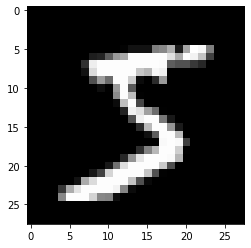

In [6]:
plt.imshow(X_train[0].reshape(28, 28))

In [19]:
def train(model, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray,
          optimizer: Optimizer, loss, epochs: int, batch_size: int):
    
    metric_names = ['loss', 'accuracy', 'f1_score']
    history = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}

    for i in range(epochs):
        for j in range(0, X_train.shape[0], batch_size):
            # print(f"epoch {i} batch {j}")
            X_batch = X_train[j:j+batch_size]
            y_batch = y_train[j:j+batch_size]
            y_pred = model.forward(X_batch)
            loss_val = loss.forward(y_pred, y_batch)
            loss_gradient = loss.backward()
            model.backward(loss_gradient)
            optimizer.step()

            y_pred_label = np.argmax(y_pred, axis=0)
            y_true_label = np.argmax(y_train, axis=0)

            history['train']['accuracy'].append(np.mean(y_pred_label == y_true_label))
            history['train']['loss'].append(loss_val)
            history['train']['f1_score'].append(f1_score(y_true_label, y_pred_label, average='macro'))

            wd = [
                np.mean([np.mean(layer.weights) for layer in model.trainable_layers]),
                np.max([np.max(layer.weights) for layer in model.trainable_layers]),
                np.mean([np.mean(layer.weights_gradient) for layer in model.trainable_layers]),
                np.max([np.max(layer.weights_gradient) for layer in model.trainable_layers])
            ]
            weights_data.append(wd)
            break

    return history

In [9]:
# train(model, X, y, optimizer, loss, 10, X.shape[-1])

In [20]:
model = Sequential([28*28, 100, 10], [SigmoidLayer, SoftMaxLayer])
optimizer = GradientDescentOptimizer(model.trainable_layers, learning_rate = 0.0001)
loss = CrossEntropyLoss()

batch_size = 1024
epochs = 1
weights_data = []

history = train(model, X_train, y_train, X_test, y_test, optimizer, loss, epochs, batch_size)

In [21]:
history['train']['loss']

[2357.9143622938154]

In [41]:
a = list(set(model.trainable_layers[1].weights_gradient.flatten()))


-450.7559896236078

In [ ]:
model.trainable_layers[0].weights_gradient.flatten()

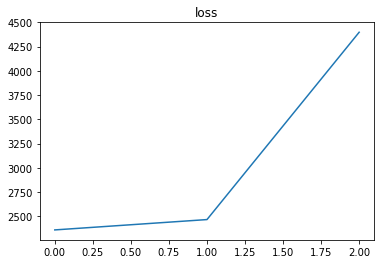

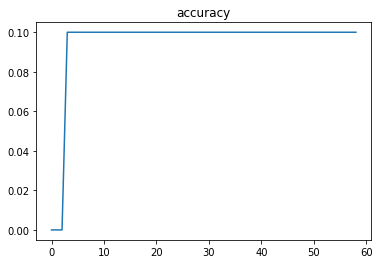

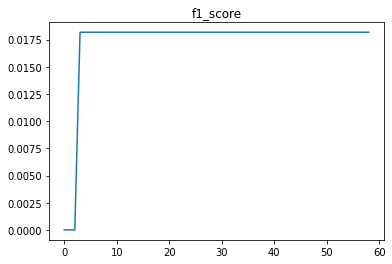

In [18]:
for key, value in history['train'].items():
    plt.plot(value)
    plt.title(key)
    plt.show()

In [12]:
a = model.forward(X_train[0])
a

array([[0.09260716, 0.10666195, 0.10282003, 0.09228981, 0.09815038,
        0.10400328, 0.10468066, 0.10314993, 0.10251105, 0.09312573]])

In [13]:
"""
def train(model, X: np.ndarray, y: np.ndarray, optimizer: Optimizer, loss, epochs: int, batch_size: int = 32, verbose: bool = True):
    for epoch in range(epochs):
        for X_batch, y_batch in get_batches(X, y, batch_size):
            y_pred = model.forward(X_batch)
            loss_gradient = loss.gradient(y_batch, y_pred)
            model.backward(loss_gradient)
            optimizer.step()
        if verbose:
            print(f"Epoch {epoch + 1}/{epochs} loss: {loss(y_batch, y_pred)}")
"""

'\ndef train(model, X: np.ndarray, y: np.ndarray, optimizer: Optimizer, loss, epochs: int, batch_size: int = 32, verbose: bool = True):\n    for epoch in range(epochs):\n        for X_batch, y_batch in get_batches(X, y, batch_size):\n            y_pred = model.forward(X_batch)\n            loss_gradient = loss.gradient(y_batch, y_pred)\n            model.backward(loss_gradient)\n            optimizer.step()\n        if verbose:\n            print(f"Epoch {epoch + 1}/{epochs} loss: {loss(y_batch, y_pred)}")\n'

In [14]:
import torch

c:\Users\SystemPoint\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:


X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train)

X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test)

def train_torch(model, X_train: torch.Tensor, y_train: torch.Tensor, X_test: torch.Tensor, y_test: torch.Tensor,
          optimizer, loss, epochs: int, batch_size: int):
    
    metric_names = ['loss', 'accuracy', 'f1_score']
    history = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}

    for i in range(epochs):
        for j in range(0, X_train.shape[0], batch_size):
            # print(f"epoch {i} batch {j}")
            X_batch = X_train[j:j+batch_size]
            y_batch = y_train[j:j+batch_size]
            y_pred = model(X_batch)
            loss_val = loss(y_pred, y_batch)
            model.zero_grad()
            loss_val.backward()
            optimizer.step()

            y_pred_label = np.argmax(y_pred.detach().numpy(), axis=0)
            y_true_label = np.argmax(y_train.detach().numpy(), axis=0)

            history['train']['accuracy'].append(np.mean(y_pred_label == y_true_label).item())
            history['train']['loss'].append(loss_val.item())
            history['train']['f1_score'].append(f1_score(y_true_label, y_pred_label, average='macro').item())

    return history

In [16]:
model_torch = torch.nn.Sequential(
    torch.nn.Linear(28*28, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10),
    torch.nn.Softmax()
)

weights_data_torch = []

optimizer_torch = torch.optim.Adam(model_torch.parameters(), lr=0.001)

loss_torch = torch.nn.CrossEntropyLoss()

history_torch = train_torch(model_torch, X_train_torch, y_train_torch, X_test_torch, y_test_torch, optimizer_torch, loss_torch, 10, 1024)

c:\Users\SystemPoint\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
c:\Users\SystemPoint\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
c:\Users\SystemPoint\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
c:\Users\SystemPoint\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as a

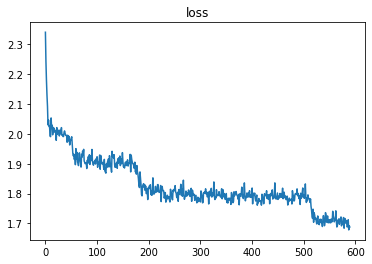

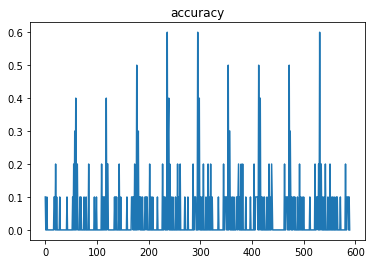

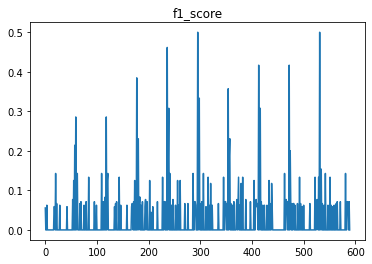

In [17]:
for key, value in history_torch['train'].items():
    plt.plot(value)
    plt.title(key)
    plt.show()

In [18]:
history_torch['train']['loss'][0]

2.3405694811372086

In [19]:
import torch
torch.use_deterministic_algorithms(True)

batch_size = 10

my_fc = FullyConnectedLayer(28*28, 100)
torch_fc = torch.nn.Linear(28*28, 100)
print(my_fc.weights.shape, torch_fc.weight.shape, my_fc.bias.shape, torch_fc.bias.shape)
my_fc.weights = torch_fc.weight.detach().numpy().T
my_fc.bias = torch_fc.bias.detach().numpy().reshape(-1, 1).T

my_out = my_fc.forward(X_train[0: batch_size].reshape(batch_size, -1))
torch_out = torch_fc(torch.from_numpy(X_train[0: batch_size]).float())
torch_out_np = torch_out.detach().numpy()

print(np.allclose(my_out, torch_out_np))
print(np.abs(my_out - torch_out_np).sum())

t_s = torch.sum(torch_out)
t_s.backward()

print(torch_fc.weight.grad)



print(my_fc.input_.shape)
my_in_g = my_fc.backward(my_out)

my_wg = my_fc.weights_gradient
torch_wg = torch_fc.weight.grad.detach().numpy().T
gradien_close = np.allclose(my_wg, torch_wg)

wg_diff = np.abs(my_wg - torch_wg)
print(wg_diff.sum())

print(gradien_close)

(784, 100) torch.Size([100, 784]) (1, 100) torch.Size([100])
False
0.005809158
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
(10, 784)
687717900.0
False


In [20]:
torch_wg1 = torch_fc.weight.grad.detach().numpy().T

In [21]:
torch_wg.mean()

298.85715

In [22]:
my_wg.mean()

1204.0897

In [23]:
my_fc.weights.shape

(784, 100)

In [24]:
torch_fc.weight.shape

torch.Size([100, 784])

In [25]:
torch_fc.weight

Parameter containing:
tensor([[ 0.0003, -0.0138, -0.0104,  ..., -0.0102,  0.0285,  0.0207],
        [-0.0048, -0.0111, -0.0354,  ..., -0.0344,  0.0087, -0.0261],
        [-0.0070, -0.0289, -0.0262,  ..., -0.0200, -0.0138,  0.0214],
        ...,
        [ 0.0271,  0.0333, -0.0337,  ..., -0.0196,  0.0093,  0.0341],
        [ 0.0041, -0.0120, -0.0117,  ...,  0.0104,  0.0024, -0.0095],
        [-0.0260,  0.0062,  0.0209,  ...,  0.0202, -0.0242, -0.0049]],
       requires_grad=True)

In [26]:
torch_fc = torch.nn.Linear(28*28, 100)
torch_fc(X_train_torch[0])



tensor([  34.6568,  -78.9073,  -70.0834,   51.4167,  -44.9047,   39.4317,
          42.3296,   63.4073,  -39.3705,  -58.6149,  -37.1483,  148.8779,
           0.9253,   43.2241,   72.2168,   -4.1248, -111.0600,   94.8676,
          86.9571,  -32.1242,  -35.2513,   33.1849,  -86.2087,   12.6508,
         -42.3553,   -7.6972,  -40.9072,  -49.7871,  -49.5850,  -11.8226,
          60.5636,   64.6711,   -4.3236,   88.8208,   10.2747,    0.5597,
          65.3381,   28.9556,   -9.1080,  -36.0084,    1.6862,   29.8354,
         -33.2820,  -27.2965,  -13.0205,   56.4513,   96.9946,  -41.2365,
          21.5729,  -16.5399,   50.8962,   15.7225,  -33.7532,   39.9822,
          52.4159,   27.1666,   25.3686,   -9.1890,   30.8338,  -49.9591,
          43.5993,  -22.7844,   25.6199,  -65.1438,   27.7499,   84.8461,
          15.5694,  -12.5393, -109.0596,   45.3083,  -42.0051,   55.7345,
          -0.9913,  -87.7294,   23.7525,   19.5455,   -2.3507,   81.3224,
          24.8760,  -65.4326,  -39.048